# 4. Hypoglycaemic episodes
This notebook looks into the identification of hypoglycaemic episodes from the data created in [section 1](..file-types/1_create_df.ipynb). Episodes are identified in 5-minute data, cut 15-minute data, and interpolated 5-minute data (from the 15-minute data). These episodes are recorded with start and end time, which are then used to check if they overlap with the 5-minute dataset. This is used to determine the number of true positives, false positives and false negatives, compare to the 5-minute 'gold standard'. The results are stored in results_frame at the end of section 3.2 and are divided into all hypoglycaemic episodes, level 1 and level 2 episodes.
Section 3.3. then shows a figure with some examples of how the interpolation can be correct and incorrect and section 3.4. shows the what the incorrect level 1 and level 2 hypos are labelled as.

## 4.1. Import packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import calc_episodes

In [2]:
interpolated_cgm = pd.read_csv('../data/interpolated_cgm.csv')
interpolated_cgm.dropna(subset=['glc'], inplace=True)
interpolated_cgm['time'] = pd.to_datetime(interpolated_cgm['time'])

## Calculate episodes

In [3]:
# Main processing for interpolation methods
methods = ['glc', 'cut_glc', 'pchip', 'linear', 'cubicspline', 'polynomial_3', 'polynomial_5', 'polynomial_7']
results_dict = {}

# Assuming 'interpolated_cgm' DataFrame exists and contains the necessary data
for method in methods:
    sub_df = interpolated_cgm[['time', 'ID', method]]
    sub_df.columns = ['time', 'ID', 'glc']
    
    # Group by 'ID' and apply calculate_episodes for each group
    method_results = sub_df.groupby('ID').apply(lambda x: calc_episodes.calculate_episodes(x, hypo=True, thresh=3.9, thresh_lv2=3, mins=15, long_mins=120))
    results_dict[f'hypo_{method}'] = method_results

    method_results_hyper = sub_df.groupby('ID').apply(lambda x: calc_episodes.calculate_episodes(x, hypo=False, thresh=10, thresh_lv2=13.9, mins=15, long_mins=120))
    results_dict[f'hyper_{method}'] = method_results_hyper

In [4]:
# Loop through the dictionary and save each DataFrame with its variable name
for name, df in results_dict.items():
    df.to_csv(f'../data/glycemic_events/{name}.csv', index=False)

## Assessing concordance

In [5]:
def overlapping_frame(row, dataframe):
    '''
    Returns all rows of the dataframe with that overlap with the start and end
    end time of the row
    '''
    return dataframe.loc[(dataframe['ID'] == row['ID']) &
                         (((dataframe['start_time'] <= row['start_time']) &
                           (dataframe['end_time'] >= row['start_time']))|
                          ((dataframe['start_time'] <= row['end_time']) &
                           (dataframe['end_time'] >= row['end_time'])) |
                          ((row['start_time'] <= dataframe['start_time']) &
                           (row['end_time'] >= dataframe['start_time']))|
                          ((row['start_time'] <= dataframe['end_time']) &
                           (row['end_time'] >= dataframe['end_time'])))]

In [6]:
def calculate_confusion_matrix(original_df, comparison_df):
    false_positive_lv2 = 0
    false_positive_lv1 = 0
    true_positive_lv1 = 0
    true_positive_lv2 = 0
    # identified as lv2, actually none
    false_positive_lv2_none = 0
    # identified as lv2, actually lv1
    false_positive_lv2_lv1 = 0
    false_negative_lv2 = 0
    # actual level 2, identified as none
    false_negative_lv2_none = 0
    # actual lv2, identified as none
    false_negative_lv2_lv1 = 0
    false_negative_lv1 = 0

    copy_comparison = comparison_df.copy()#.sort_values('lv2', ascending=False)

    for i, row in original_df.iterrows():
        sub_df = overlapping_frame(row, copy_comparison)
        overlap_count = sub_df.shape[0]
        lv2 = row['lv2']

        if overlap_count == 0:
            false_negative_lv1 += 1
            if lv2:
                false_negative_lv2 += 1
                false_negative_lv2_none += 1
        
        elif overlap_count == 1:
            true_positive_lv1 += 1
            if lv2 and sub_df['lv2'].any():
                true_positive_lv2 += 1
                
            elif lv2:
                false_negative_lv2 += 1
                false_negative_lv2_lv1 += 1
            
            elif sub_df['lv2'].any():
                false_positive_lv2 += 1
                false_positive_lv2_lv1 +=1
            
            copy_comparison = copy_comparison.drop(index=sub_df.index)
            
                
        else:
            true_positive_lv1 += 1
            if sub_df['lv2'].any():
                index = [sub_df[sub_df['lv2']].index[0]]
                if lv2:
                    true_positive_lv2 += 1
                else:
                    false_positive_lv2 += 1
                #matched_indices.add([index])
            else:
                if lv2:
                    false_negative_lv2 += 1
                index = [sub_df.index[0]]
                #matched_indices.update([sub_df.index[0]])
            
            copy_comparison = copy_comparison.drop(index=index)


    # Calculate false positives
    for i, row in copy_comparison.iterrows():
        false_positive_lv1 += 1
        if row['lv2']:
            false_positive_lv2 += 1
            false_positive_lv2_none += 1

    return {
        'true_positive_lv1': true_positive_lv1,
        'true_positive_lv2': true_positive_lv2,
        'false_negative_lv2': false_negative_lv2,
        'false_negative_lv1': false_negative_lv1,
        'false_positive_lv2': false_positive_lv2,
        'false_positive_lv1': false_positive_lv1,
        'false_negative_lv2_none': false_negative_lv2_none,
        'false_negative_lv2_lv1': false_negative_lv2_lv1,
        'false_positive_lv2_none': false_positive_lv2_none,
        'false_positive_lv2_lv1': false_positive_lv2_lv1,

    }


In [11]:
results_dict['hypo_cut_glc'].reset_index()

,ID,level_1


In [9]:
results_dict['hypo_glc']

start_time        duration            end_time    lv2  \
ID                                                                           
helm_1   0  2020-05-12 04:01:19 0 days 00:20:00 2020-05-12 04:21:19  False   
         1  2020-05-12 04:41:19 0 days 01:25:01 2020-05-12 06:06:20  False   
         2  2020-05-12 20:21:21 0 days 00:20:00 2020-05-12 20:41:21  False   
         3  2020-05-15 14:21:28 0 days 00:20:00 2020-05-15 14:41:28  False   
         4  2020-05-18 05:56:34 0 days 00:35:00 2020-05-18 06:31:34  False   
...                         ...             ...                 ...    ...   
helm_988 28 2021-04-14 15:11:32 0 days 00:40:01 2021-04-14 15:51:33  False   
         29 2021-04-15 08:06:35 0 days 00:40:01 2021-04-15 08:46:36  False   
         30 2021-04-15 10:26:36 0 days 00:39:59 2021-04-15 11:06:35  False   
         31 2021-04-15 18:56:36 0 days 00:30:00 2021-04-15 19:26:36  False   
         32 2021-04-16 17:41:39 0 days 01:00:00 2021-04-16 18:41:39  False   

            prolonged  
ID                     
helm_1   0      False  
         1      False  
         2      False  
         3      False  
         4      False  
...               ...  
helm_988 28     False  
         29     False  
         30     False  
         31     False  
         32     False  

[11111 rows x 5 columns]

In [14]:
conf_matrix= calculate_confusion_matrix(results_dict['hypo_glc'].reset_index(), results_dict['hypo_cubicspline'].reset_index())

In [ ]:
conf_matrix

{'true_positive_lv1': 11111,
 'true_positive_lv2': 2079,
 'false_negative_lv2': 0,
 'false_negative_lv1': 0,
 'false_positive_lv2': 0,
 'false_positive_lv1': 0,
 'false_negative_lv2_none': 0,
 'false_negative_lv2_lv1': 0,
 'false_positive_lv2_none': 0,
 'false_positive_lv2_lv1': 0}

### Hypos

In [ ]:
# List of DataFrames and their labels
comparison_dfs = [results_cut, results_linear, results_akima, results_pchip, results_poly3, results_poly5, results_poly7, ]
labels = ['15_min', 'linear', 'akima', 'pchip', 'poly3', 'poly5', 'poly7']

# Creating a list to store the results
results_list = []

# Iterating over the DataFrames and their labels
for df, label in zip(comparison_dfs, labels):
    results_dict = calculate_confusion_matrix(results, df)
    results_dict.update({'method':label})
    results_list.append(results_dict)
    


In [ ]:
results_frame = pd.DataFrame(results_list)

In [ ]:
df_all = results_frame[['method', 'true_positive_lv1', 'false_negative_lv1',  'false_positive_lv1',]]
df_all.columns = ['Method','TP', 'FN', 'FP']
df_all['level'] = 'all'

df_lv2 = results_frame[['method', 'true_positive_lv2', 'false_negative_lv2', 'false_positive_lv2']]
df_lv2.columns = ['Method', 'TP', 'FN', 'FP']
df_lv2['level'] = 'lv2'


df_combined = df_all.append(df_lv2)


In [ ]:
# Calculate recall, precision and critical success index
df_combined['Recall'] = df_combined['TP']/(df_combined['TP'] +
                                               df_combined['FN'])
df_combined['Precision'] = df_combined['TP']/(df_combined['TP'] +
                                             df_combined['FP'])
df_combined['CSI'] = df_combined['TP']/(df_combined['TP'] +
                                            df_combined['FP'] +
                                            df_combined['FN'])
# Sort by level, then recall, then csi
df_combined = df_combined.sort_values(['level', 'Recall', 'CSI'],
                                          ascending=True)

In [ ]:
df_combined['f1'] =( df_combined['Recall'] + df_combined['Precision'] )/2

### Hypers

In [ ]:
hyper_results.shape

(25451, 7)

In [ ]:
hyper_results.lv2.sum()

6643

In [ ]:
hyper_results_cut.shape

(23563, 7)

In [ ]:
hyper_results_cut.lv2.sum()

6190

In [ ]:
hyper_comparison_dfs = [hyper_results_cut, hyper_results_linear, hyper_results_akima, hyper_results_pchip, hyper_results_poly3, hyper_results_poly5, hyper_results_poly7, ]


In [ ]:
# List of DataFrames and their labels
hyper_comparison_dfs = [hyper_results_cut, hyper_results_linear, hyper_results_akima, hyper_results_pchip, hyper_results_poly3, hyper_results_poly5, hyper_results_poly7, ]
labels = ['15_min', 'linear', 'akima', 'pchip', 'poly3', 'poly5', 'poly7']

# Creating a list to store the results
hyper_results_list = []

# Iterating over the DataFrames and their labels
for df, label in zip(hyper_comparison_dfs, labels):
    hyper_results_dict = calculate_confusion_matrix(hyper_results, df)
    hyper_results_dict.update({'method':label})
    hyper_results_list.append(hyper_results_dict)
    


In [ ]:
hyper_results_frame = pd.DataFrame(hyper_results_list)

In [ ]:
hyper_results_frame[['method', 'false_negative_lv2','false_negative_lv2_lv1', 'false_positive_lv2', 'false_positive_lv2_lv1']]

,method,false_negative_lv2,false_negative_lv2_lv1,false_positive_lv2,false_positive_lv2_lv1
0,15_min,544,415,91,88
1,linear,190,144,95,88
2,akima,105,77,131,125
3,pchip,108,80,126,119
4,poly3,85,66,141,132
5,poly5,84,66,136,127
6,poly7,92,70,139,127


In [ ]:
df_all_hyper = hyper_results_frame[['method', 'true_positive_lv1', 'false_negative_lv1',  'false_positive_lv1',]]
df_all_hyper.columns = ['Method','TP', 'FN', 'FP']
df_all_hyper['level'] = 'all'

df_lv2_hyper = hyper_results_frame[['method', 'true_positive_lv2', 'false_negative_lv2', 'false_positive_lv2']]
df_lv2_hyper.columns = ['Method', 'TP', 'FN', 'FP']
df_lv2_hyper['level'] = 'lv2'


df_combined_hyper = df_all_hyper.append(df_lv2_hyper)


In [ ]:
(2200-441)/2200

0.7995454545454546

In [ ]:
df_combined_hyper

,Method,TP,FN,FP,level
0,15_min,23460,1991,103,all
1,linear,24757,694,361,all
2,akima,25061,390,571,all
3,pchip,25046,405,592,all
4,poly3,25167,284,696,all
5,poly5,25173,278,714,all
6,poly7,25158,293,706,all
0,15_min,6099,544,91,lv2
1,linear,6453,190,95,lv2
2,akima,6538,105,131,lv2


In [ ]:
df_combined

,Method,TP,FN,FP,level,Recall,Precision,CSI,f1
0,15_min,8968,6180,7,all,0.592025,0.999220,0.591752,0.795623
1,linear,10258,4890,27,all,0.677185,0.997375,0.675980,0.837280
2,akima,10810,4338,19,all,0.713626,0.998245,0.712732,0.855936
3,pchip,10819,4329,17,all,0.714220,0.998431,0.713419,0.856325
6,poly7,10990,4158,45,all,0.725508,0.995922,0.723359,0.860715
5,poly5,11025,4123,38,all,0.727819,0.996565,0.725998,0.862192
4,poly3,11027,4121,31,all,0.727951,0.997197,0.726464,0.862574
0,15_min,1449,2055,27,lv2,0.413527,0.981707,0.410365,0.697617
1,linear,1860,1644,27,lv2,0.530822,0.985692,0.526763,0.758257
2,akima,2064,1440,31,lv2,0.589041,0.985203,0.583876,0.787122


In [ ]:
hyper_results.lv2.sum()

6643

In [ ]:
[i.lv2.sum() for i in hyper_comparison_dfs]

[6190, 6548, 6669, 6661, 6699, 6695, 6690]

In [ ]:
hyper_results_frame

,true_positive_lv1,true_positive_lv2,false_negative_lv2,false_negative_lv1,false_positive_lv2,false_positive_lv1,false_negative_lv2_none,false_negative_lv2_lv1,false_positive_lv2_none,false_positive_lv2_lv1,method
0,23460,6099,544,1991,91,103,128,415,3,88,15_min
1,24757,6453,190,694,95,361,45,144,7,88,linear
2,25061,6538,105,390,131,571,27,77,6,125,akima
3,25046,6535,108,405,126,592,27,80,7,119,pchip
4,25167,6558,85,284,141,696,19,66,8,132,poly3
5,25173,6559,84,278,136,714,17,66,8,127,poly5
6,25158,6551,92,293,139,706,21,70,10,127,poly7


In [ ]:
# Calculate recall, precision and critical success index
df_combined_hyper['Recall'] = df_combined_hyper['TP']/(df_combined_hyper['TP'] +
                                               df_combined_hyper['FN'])
df_combined_hyper['Precision'] = df_combined_hyper['TP']/(df_combined_hyper['TP'] +
                                             df_combined_hyper['FP'])
df_combined_hyper['CSI'] = df_combined_hyper['TP']/(df_combined_hyper['TP'] +
                                            df_combined_hyper['FP'] +
                                            df_combined_hyper['FN'])
# Sort by level, then recall, then csi
df_combined_hyper = df_combined_hyper.sort_values(['level', 'Recall', 'CSI'],
                                          ascending=True)

In [ ]:
df_combined_hyper['f1'] =( df_combined_hyper['Recall'] + df_combined_hyper['Precision'] )/2

In [ ]:
df_combined_hyper

,Method,TP,FN,FP,level,Recall,Precision,CSI,f1
0,15_min,23460,1991,103,all,0.921771,0.995629,0.918056,0.958700
1,linear,24757,694,361,all,0.972732,0.985628,0.959128,0.979180
3,pchip,25046,405,592,all,0.984087,0.976909,0.961717,0.980498
2,akima,25061,390,571,all,0.984676,0.977723,0.963070,0.981200
6,poly7,25158,293,706,all,0.988488,0.972703,0.961808,0.980596
4,poly3,25167,284,696,all,0.988841,0.973089,0.962520,0.980965
5,poly5,25173,278,714,all,0.989077,0.972419,0.962087,0.980748
0,15_min,6099,544,91,lv2,0.918109,0.985299,0.905702,0.951704
1,linear,6453,190,95,lv2,0.971398,0.985492,0.957703,0.978445
3,pchip,6535,108,126,lv2,0.983742,0.981084,0.965431,0.982413


In [ ]:
# Replace labels for legend of plot
names = {'15_min':'15-minute intervals', 
         'linear':'Linear interp.', 
          'akima':'Akima interp.', 
          'pchip':'PCHIP interp.', 
         'poly3':'Poly. 3 interp.', 
         'poly5':'Poly. 5 interp.',
        'poly7':'Poly. 7 interp.'}
df_combined.Method = df_combined.Method.replace(names)
df_combined_hyper.Method = df_combined_hyper.Method.replace(names)

# Order of legend
hue_order = ['15-minute intervals', 'Linear interp.', 'Poly. 3 interp.', 'Poly. 5 interp.', 'Poly. 7 interp.', 'Akima interp.', 'PCHIP interp.']

In [ ]:
df_combined_hyper.sort_values(['level', 'f1'])

,Method,TP,FN,FP,level,Recall,Precision,CSI,f1
0,15-minute intervals,23460,1991,103,all,0.921771,0.995629,0.918056,0.958700
1,Linear interp.,24757,694,361,all,0.972732,0.985628,0.959128,0.979180
3,PCHIP interp.,25046,405,592,all,0.984087,0.976909,0.961717,0.980498
6,Poly. 7 interp.,25158,293,706,all,0.988488,0.972703,0.961808,0.980596
5,Poly. 5 interp.,25173,278,714,all,0.989077,0.972419,0.962087,0.980748
4,Poly. 3 interp.,25167,284,696,all,0.988841,0.973089,0.962520,0.980965
2,Akima interp.,25061,390,571,all,0.984676,0.977723,0.963070,0.981200
0,15-minute intervals,6099,544,91,lv2,0.918109,0.985299,0.905702,0.951704
1,Linear interp.,6453,190,95,lv2,0.971398,0.985492,0.957703,0.978445
2,Akima interp.,6538,105,131,lv2,0.984194,0.980357,0.965161,0.982275


In [ ]:
df_combined.sort_values(['level', 'f1'])

,Method,TP,FN,FP,level,Recall,Precision,CSI,f1
0,15-minute intervals,8968,6180,7,all,0.592025,0.999220,0.591752,0.795623
1,Linear interp.,10258,4890,27,all,0.677185,0.997375,0.675980,0.837280
2,Akima interp.,10810,4338,19,all,0.713626,0.998245,0.712732,0.855936
3,PCHIP interp.,10819,4329,17,all,0.714220,0.998431,0.713419,0.856325
6,Poly. 7 interp.,10990,4158,45,all,0.725508,0.995922,0.723359,0.860715
5,Poly. 5 interp.,11025,4123,38,all,0.727819,0.996565,0.725998,0.862192
4,Poly. 3 interp.,11027,4121,31,all,0.727951,0.997197,0.726464,0.862574
0,15-minute intervals,1449,2055,27,lv2,0.413527,0.981707,0.410365,0.697617
1,Linear interp.,1860,1644,27,lv2,0.530822,0.985692,0.526763,0.758257
2,Akima interp.,2064,1440,31,lv2,0.589041,0.985203,0.583876,0.787122


## Pareto front

In [ ]:
def identify_pareto(scores):
    '''
    Function to calculate Pareto front of methods from Python for Healthcare by
    Mike Allen
    '''
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

In [ ]:
def compute_pareto_coords(dataframe):
    '''
    Computes the precision-recall coordinates to plot on the plots using 
    identify_pareto
    '''
    pareto = identify_pareto(np.array(dataframe[['Recall', 'Precision']]))
    pareto_front = np.array(dataframe[['Recall', 'Precision']])[pareto]

    pareto_front_df = pd.DataFrame(pareto_front)
    pareto_front_df.sort_values(0, inplace=True)
    pareto_front = pareto_front_df.values

    x_pareto = pareto_front[:, 0]
    y_pareto = pareto_front[:, 1]
    
    return x_pareto, y_pareto

In [ ]:
lv_all  = df_combined[df_combined['level']=='all']
lv2 = df_combined[df_combined['level']=='lv2']

lv_all_hyper  = df_combined_hyper[df_combined_hyper['level']=='all']
lv2_hyper = df_combined_hyper[df_combined_hyper['level']=='lv2']

In [ ]:
df_combined_hyper.to_csv('data/df_combined_hyper.csv', index=False)

In [ ]:
# Get pareto coordinates to plot on fig
x_pareto, y_pareto = compute_pareto_coords(lv_all)
x_pareto2, y_pareto2 = compute_pareto_coords(lv2)

# Get pareto coordinates to plot on fig
x_pareto_hyper, y_pareto_hyper = compute_pareto_coords(lv_all_hyper)
x_pareto2_hyper, y_pareto2_hyper = compute_pareto_coords(lv2_hyper)

In [ ]:
lv_all['Percentage change'] = 100*(lv_all['TP'] + lv_all['FP'] - 11111)/11111
lv2['Percentage change'] = 100*(lv2['TP'] + lv2['FP'] - 2079)/2079

lv_all_hyper['Percentage change'] = 100*(lv_all_hyper['TP'] + lv_all_hyper['FP'] - 25451)/25451
lv2_hyper['Percentage change'] = 100*(lv2_hyper['TP'] + lv2_hyper['FP'] - 6643)/6643

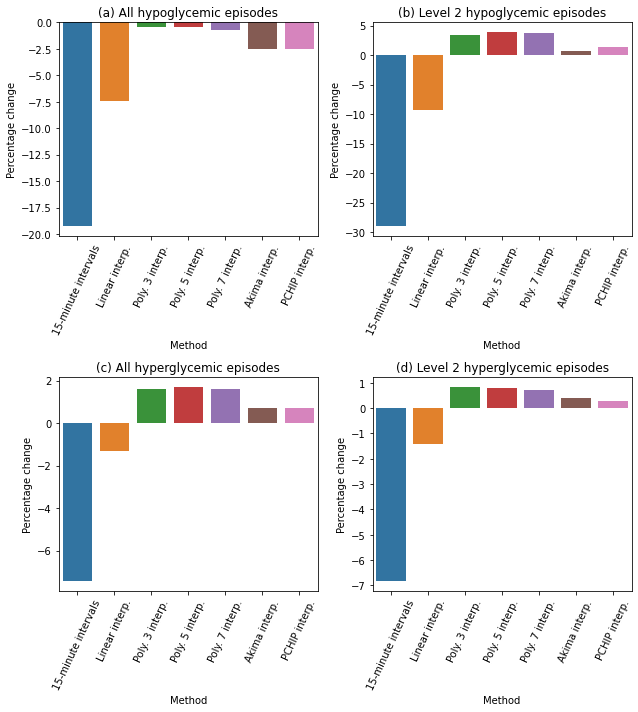

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(9, 10))

sns.barplot(data=lv_all, x='Method', y='Percentage change', hue_order=hue_order, order=hue_order, ax=ax[0, 0])
ax[0, 0].set_title('(a) All hypoglycemic episodes')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=65)

sns.barplot(data=lv2, x='Method', y='Percentage change', hue_order=hue_order, order=hue_order, ax=ax[0, 1])
ax[0, 1].set_title('(b) Level 2 hypoglycemic episodes')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=65)

sns.barplot(data=lv_all_hyper, x='Method', y='Percentage change', hue_order=hue_order, order=hue_order, ax=ax[1, 0])
ax[1, 0].set_title('(c) All hyperglycemic episodes')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=65)

sns.barplot(data=lv2_hyper, x='Method', y='Percentage change', hue_order=hue_order, order=hue_order, ax=ax[1, 1])
ax[1, 1].set_title('(d) Level 2 hyperglycemic episodes')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=65)

plt.tight_layout()
plt.show()



In [ ]:
fig.savefig('figures/percentage_change.eps', bbox_inches='tight')

[<matplotlib.collections.PathCollection object at 0x7f18cc438f10>, <matplotlib.collections.PathCollection object at 0x7f18cc438ac0>, <matplotlib.collections.PathCollection object at 0x7f18cc27ac70>, <matplotlib.collections.PathCollection object at 0x7f18cf065a60>, <matplotlib.collections.PathCollection object at 0x7f18c7491c40>, <matplotlib.collections.PathCollection object at 0x7f18cc438340>, <matplotlib.collections.PathCollection object at 0x7f18c74a6880>]


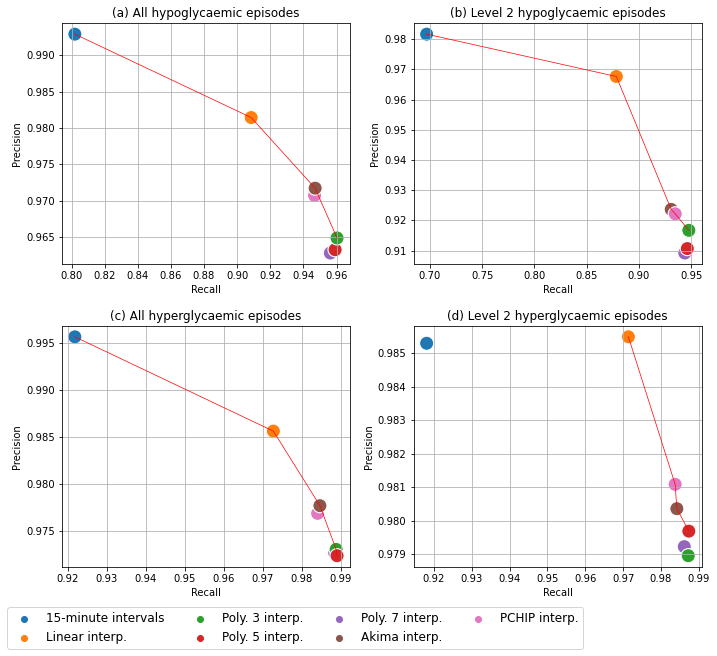

In [ ]:
# Plote level 2 hypos
fig, ax = plt.subplots(2,2, figsize=(10, 8))
# all hypos
sns.scatterplot(y=lv_all.Precision, x=lv_all.Recall, hue=lv_all['Method'], hue_order=hue_order,
                 ax=ax[0,0], s=200)
ax[0,0].grid(True)  # This will add gridlines to the plot

ax[0,0].plot(x_pareto, y_pareto, color='r', linewidth=0.7)

ax[0,0].get_legend().remove()
ax[0,0].set_title('(a) All hypoglycaemic episodes') 

#lv2
ax[0,1].plot(x_pareto2, y_pareto2, color='r', linewidth=0.7)
sns.scatterplot(y=lv2.Precision, x=lv2.Recall, hue=lv2['Method'], ax=ax[0,1],
                hue_order=hue_order, s=200
                )

ax[0,1].grid(True)  # This will add gridlines to the plot
ax[0,1].set_title('(b) Level 2 hypoglycaemic episodes') 
ax[0,1].get_legend().remove()
ax[1, 0].set_title('(c) All hyperglycaemic episodes')


sns.scatterplot(y=lv_all_hyper.Precision, x=lv_all_hyper.Recall, hue=lv_all_hyper['Method'], hue_order=hue_order,
                 ax=ax[1,0], s=200)
ax[1,0].grid(True)  # This will add gridlines to the plot
ax[1,0].plot(x_pareto_hyper, y_pareto_hyper, color='r', linewidth=0.7)
ax[1,0].get_legend().remove()


sns.scatterplot(y=lv2_hyper.Precision, x=lv2_hyper.Recall, hue=lv2_hyper['Method'], hue_order=hue_order,
                 ax=ax[1,1], s=200)
ax[1,1].grid(True)  # This will add gridlines to the plot
ax[1,1].plot(x_pareto2_hyper, y_pareto2_hyper, color='r', linewidth=0.7)
ax[1, 1].set_title('(d) Level 2 hyperglycaemic episodes')
ax[1,1].get_legend().remove()

# Step 1: Collect handles and labels for the legend
handles, labels = ax[0, 0].get_legend_handles_labels()

# Reorder handles and labels according to 'desired_order'
handles_dict = dict(zip(labels, handles))  # Map current labels to their handles
ordered_handles = [handles_dict[label] for label in hue_order if label in handles_dict]

print(ordered_handles)
# Create a single legend for the figure, placing it at the bottom left, with items arranged horizontally
fig.legend(ordered_handles, hue_order, loc='upper left', bbox_to_anchor=(0, -0.05), fontsize='large', ncol=4)

# Adjust the layout to make room for the legend at the bottom
fig.tight_layout()
fig.subplots_adjust(bottom=0.01) 
#plt.grid(True)  # This will add gridlines to the plot
#plt.legend(fontsize='large')  # You can use 'small', 'medium', 'large', 'x-large', etc.


#fig.tight_layout()
fig.savefig('Fig3.svg')

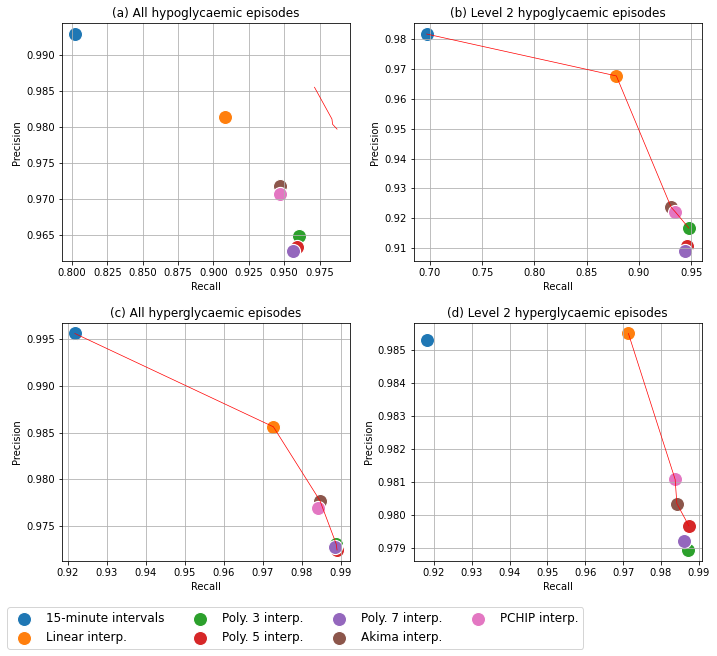

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming lv_all, lv2, lv_all_hyper, lv2_hyper DataFrames and x_pareto, y_pareto, etc. are defined

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Define the hue order
hue_order = [
    '15-minute intervals', 'Linear interp.', 'Poly. 3 interp.',
    'Poly. 5 interp.', 'Poly. 7 interp.', 'Akima interp.', 'PCHIP interp.'
]

# Plot settings for each subplot including title and Pareto front
plot_settings = [
    (lv_all, x_pareto, y_pareto, '(a) All hypoglycaemic episodes'),
    (lv2, x_pareto2, y_pareto2, '(b) Level 2 hypoglycaemic episodes'),
    (lv_all_hyper, x_pareto_hyper, y_pareto_hyper, '(c) All hyperglycaemic episodes'),
    (lv2_hyper, x_pareto2_hyper, y_pareto2_hyper, '(d) Level 2 hyperglycaemic episodes')
]

for (dataframe, x_pareto, y_pareto, title), axis in zip(plot_settings, ax.flatten()):
    # Plot Pareto front
    axis.plot(x_pareto, y_pareto, color='r', linewidth=0.7)
    
    # Plot each method in the defined order
    for method in hue_order:
        filtered_data = dataframe[dataframe['Method'] == method]
        sns.scatterplot(x=filtered_data['Recall'], y=filtered_data['Precision'], label=method, ax=axis, s=200)

    axis.grid(True)
    axis.set_title(title)
    axis.get_legend().remove()  # Remove individual subplot legends

# Collect handles and labels from the last plot
handles, labels = ax[-1, -1].get_legend_handles_labels()

# Create a single, ordered legend at the bottom left of the figure
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, -0.05), fontsize='large', ncol=4)

# Adjust layout
fig.tight_layout()
fig.subplots_adjust(bottom=0.02)  # Adjust the bottom to make space for the legend

fig.savefig('Fig3.svg')


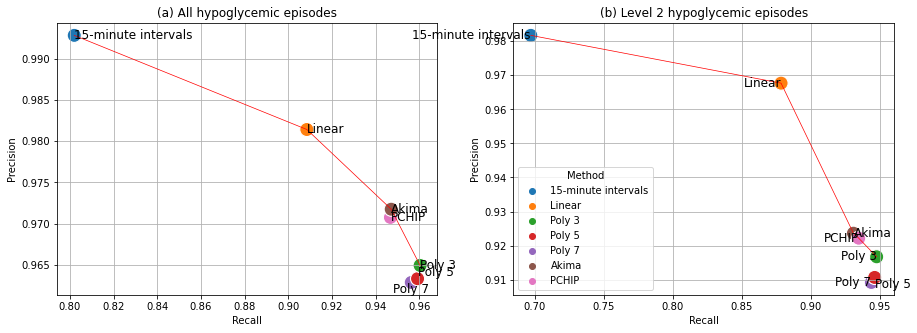

In [ ]:
import seaborn as sns
# Plote level 2 hypos
fig, ax = plt.subplots(1,2, figsize=(15, 5))
# all hypos
sns.scatterplot(y=lv_all.Precision, x=lv_all.Recall, hue=lv_all['Method'], hue_order=hue_order,
                 ax=ax[0], s=200)
ax[0].grid(True)  # This will add gridlines to the plot

ax[0].plot(x_pareto, y_pareto, color='r', linewidth=0.7)
for i, txt in enumerate(lv_all.Method):
    hal='left'
    vert='center'
    if (txt == 'GP(RBF)'):# | (txt == 'Linear'):
        hal = 'right'
    if txt == 'Poly 7':
        vert = 'top'
        hal = 'center'
    if (txt == 'GP(Matern)') | (txt == 'Poly 5') | (txt == 'GP(RBF)'):
        vert = 'bottom'
    ax[0].annotate(lv_all.Method.iloc[i], (lv_all.Recall.iloc[i],
                                        lv_all.Precision.iloc[i]),
                horizontalalignment=hal, verticalalignment=vert, fontsize=12)#, weight='ultralight',)
ax[0].get_legend().remove()
ax[0].set_title('(a) All hypoglycemic episodes') 

#lv2
ax[1].plot(x_pareto2, y_pareto2, color='r', linewidth=0.7)
sns.scatterplot(y=lv2.Precision, x=lv2.Recall, hue=lv2['Method'], ax=ax[1],
                hue_order=hue_order, s=200
                )
for i, txt in enumerate(lv2.Method):
    #print(txt)
    hal = 'right'
    vert='center'
    #if txt == 'Cubic spline':
    #    vert = 'bottom'
    if (txt == 'GP(Matern)')|(txt == 'Akima') | (txt == 'None') | (txt == 'Poly 5'):
        hal = 'left'
        #vert='bottom'
    if txt == 'Poly 5':
        vert='top'
    ax[1].annotate(txt, (lv2.Recall.iloc[i],
                                     lv2.Precision.iloc[i]),
                horizontalalignment=hal, verticalalignment=vert, fontsize=12)
                #weight='ultralight')
#ax[1].get_legend().remove()
ax[1].set_title('(b) Level 2 hypoglycemic episodes') 

plt.grid(True)  # This will add gridlines to the plot

#fig.tight_layout()
fig.savefig('Fig3.svg')

In [ ]:
calculate_confusion_matrix(results, results_cut, '15min')

TypeError: calculate_confusion_matrix() takes 2 positional arguments but 3 were given

In [ ]:
conf_matrix

{'true_positive_lv1': 8911,
 'true_positive_lv2': 1449,
 'false_negative_lv2': 630,
 'false_negative_lv1': 2200,
 'false_positive_lv2': 27,
 'false_positive_lv1': 64,
 'false_negative_lv2_none': 61,
 'false_negative_lv2_lv1': 569,
 'false_positive_lv2_none': 1,
 'false_positive_lv2_lv1': 26}

In [ ]:
conf_matrix['false_positive_lv2'] + conf_matrix['true_positive_lv2']

1476

In [ ]:
2079 - conf_matrix['false_negative_lv2'] + conf_matrix['false_positive_lv2']

1476

In [ ]:
conf_matrix['false_positive_lv1'] + conf_matrix['true_positive_lv1']

8975

In [ ]:
conf_matrix['false_positive_lv1'] + conf_matrix['true_positive_lv1']

8975

In [ ]:
11111-conf_matrix['false_negative_lv1'] + conf_matrix['false_positive_lv1']

8975

In [ ]:
pd.DataFrame(aligned_results)

,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value
0,15min,helm_1,2020-05-12 04:01:19,2020-05-12 04:01:19,2020-05-12 04:21:19,0 days 00:20:00,False,2020-05-12 04:01:19,2020-05-12 06:16:20,0 days 02:15:01,False,0
1,15min,helm_1,2020-05-12 04:41:19,2020-05-12 04:41:19,2020-05-12 06:06:20,0 days 01:25:01,False,NaT,NaT,NaT,NaN,-1
2,15min,helm_1,2020-05-12 20:21:21,2020-05-12 20:21:21,2020-05-12 20:41:21,0 days 00:20:00,False,NaT,NaT,NaT,NaN,-1
3,15min,helm_1,2020-05-15 14:21:28,2020-05-15 14:21:28,2020-05-15 14:41:28,0 days 00:20:00,False,NaT,NaT,NaT,NaN,-1
4,15min,helm_1,2020-05-18 05:56:34,2020-05-18 05:56:34,2020-05-18 06:31:34,0 days 00:35:00,False,2020-05-18 06:01:33,2020-05-18 06:31:34,0 days 00:30:01,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11170,15min,helm_834,2020-06-26 20:36:55,NaT,NaT,NaT,NaN,2020-06-26 20:36:55,2020-06-26 21:06:55,-294 days +03:20:16,False,1
11171,15min,helm_854,2020-10-03 06:09:45,NaT,NaT,NaT,NaN,2020-10-03 06:09:45,2020-10-03 06:39:45,-196 days +12:53:06,False,1
11172,15min,helm_893,2020-04-29 03:30:43,NaT,NaT,NaT,NaN,2020-04-29 03:30:43,2020-04-29 04:00:43,-353 days +10:14:04,False,1
11173,15min,helm_953,2020-11-10 00:43:01,NaT,NaT,NaT,NaN,2020-11-10 00:43:01,2020-11-10 01:27:56,-158 days +07:41:17,False,1


In [ ]:
comparison_lv2.sum()

NameError: name 'comparison_lv2' is not defined

In [ ]:
aligned

,col,ID,global_start,false_value,original_start,original_end,original_diff,original_lv2,comparison_start,comparison_end,comparison_diff,comparison_lv2,lv2_value
0,15min,helm_1,2020-05-12 04:01:19,0,2020-05-12 04:01:19,2020-05-12 04:21:19,0 days 00:20:00,False,2020-05-12 04:01:19,2020-05-12 06:16:20,0 days 02:15:01,False,0
1,15min,helm_1,2020-05-12 04:41:19,0,2020-05-12 04:41:19,2020-05-12 06:06:20,0 days 01:25:01,False,2020-05-12 04:01:19,2020-05-12 06:16:20,0 days 02:15:01,False,0
2,15min,helm_1,2020-05-12 20:21:21,-1,2020-05-12 20:21:21,2020-05-12 20:41:21,0 days 00:20:00,False,NaT,NaT,NaT,NaN,NaN
3,15min,helm_1,2020-05-15 14:21:28,-1,2020-05-15 14:21:28,2020-05-15 14:41:28,0 days 00:20:00,False,NaT,NaT,NaT,NaN,NaN
4,15min,helm_1,2020-05-18 05:56:34,0,2020-05-18 05:56:34,2020-05-18 06:31:34,0 days 00:35:00,False,2020-05-18 06:01:33,2020-05-18 06:31:34,0 days 00:30:01,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11166,15min,helm_834,2020-06-26 20:36:55,1,2020-06-26 20:36:55,2020-06-26 21:06:55,0 days 00:30:00,False,NaT,NaT,NaT,NaN,NaN
11167,15min,helm_854,2020-10-03 06:09:45,1,2020-10-03 06:09:45,2020-10-03 06:39:45,0 days 00:30:00,False,NaT,NaT,NaT,NaN,NaN
11168,15min,helm_893,2020-04-29 03:30:43,1,2020-04-29 03:30:43,2020-04-29 04:00:43,0 days 00:30:00,False,NaT,NaT,NaT,NaN,NaN
11169,15min,helm_953,2020-11-10 00:43:01,1,2020-11-10 00:43:01,2020-11-10 01:27:56,0 days 00:44:55,False,NaT,NaT,NaT,NaN,NaN


In [ ]:
results_cut.lv2.sum()


1476

In [ ]:
aligned['comparison_lv2'].sum()

1517

In [ ]:
aligned['lv2_value'] = aligned['original_lv2']-aligned['comparison_lv2']

In [ ]:
results_lv2 = results[results['lv2'] == True].reset_index(drop=True)

results_cut_lv2 = results_cut[results_cut['lv2'] == True].reset_index(drop=True)

In [ ]:
calculate_confusion_matrix(results_lv2, results_cut_lv2, '15min')

[1473, 606, 14]

In [ ]:
results 

,ID,level_1,start_time,duration,end_time,lv2,prolonged
0,helm_1,0,2020-05-12 04:01:19,0 days 00:20:00,2020-05-12 04:21:19,False,False
1,helm_1,1,2020-05-12 04:41:19,0 days 01:25:01,2020-05-12 06:06:20,False,False
2,helm_1,2,2020-05-12 20:21:21,0 days 00:20:00,2020-05-12 20:41:21,False,False
3,helm_1,3,2020-05-15 14:21:28,0 days 00:20:00,2020-05-15 14:41:28,False,False
4,helm_1,4,2020-05-18 05:56:34,0 days 00:35:00,2020-05-18 06:31:34,False,False
...,...,...,...,...,...,...,...
11106,helm_988,28,2021-04-14 15:11:32,0 days 00:40:01,2021-04-14 15:51:33,False,False
11107,helm_988,29,2021-04-15 08:06:35,0 days 00:40:01,2021-04-15 08:46:36,False,False
11108,helm_988,30,2021-04-15 10:26:36,0 days 00:39:59,2021-04-15 11:06:35,False,False
11109,helm_988,31,2021-04-15 18:56:36,0 days 00:30:00,2021-04-15 19:26:36,False,False


In [ ]:

def extract_confusion_matrix_values(original_df, compare_df, df_label, aligned=False):
    """
    Apply the calculate_confusion_matrix function to the given DataFrame 
    and extract TP, FN, FP values.
    """
    # Assuming calculate_confusion_matrix is defined elsewhere and works correctly
    tp, fn, fp = calculate_confusion_matrix(original_df, compare_df, df_label, aligned)
    return tp, fn, fp

# List of DataFrames and their labels
dfs = [results_cut, results_linear, results_akima, results_pchip, results_poly3, results_poly5, results_poly7]
labels = ['15_min', 'linear', 'akima', 'pchip', 'poly3', 'poly5', 'poly7']

# Creating a list to store the results
results_list = []

# Iterating over the DataFrames and their labels
for df, label in zip(dfs, labels):
    tp, fn, fp = extract_confusion_matrix_values(results, df, label, True)
    results_list.append({'Label': label, 'LV': 'all', 'TP': tp, 'FN': fn, 'FP': fp})

    # Calculate confusion matrix for level 2 hypos only
    df_lv2 = df[df['lv2'] == True].reset_index(drop=True)
    results_lv2 = results[results['lv2'] == True].reset_index(drop=True)
    tp, fn, fp = extract_confusion_matrix_values(results_lv2, df_lv2, label)
    results_list.append({'Label': label, 'LV': 'lv2', 'TP': tp, 'FN': fn, 'FP': fp})

# Creating a DataFrame from the results
results_df = pd.DataFrame(results_list)

# Setting the 'Label' column as index
results_df.set_index('Label', inplace=True)


KeyError: 'ID'

In [ ]:
results_df

,LV,TP,FN,FP
Label,,,,
15_min,all,8911,2200,64
15_min,lv2,1461,618,15
linear,all,10094,1017,191
linear,lv2,1832,247,55
akima,all,10523,588,306
akima,lv2,1942,137,153
pchip,all,10519,592,317
pchip,lv2,1949,130,158
poly3,all,10670,441,388


In [ ]:
results_frame = results_df.reset_index()

In [ ]:
results_frame.round(3)
results_frame['predicted_positives'] = results_frame['TP'] + results_frame['FP']

In [ ]:
results_frame

,Label,LV,TP,FN,FP,recall,prec,csi,Positives,predicted_positives
0,15_min,all,8911,2200,64,0.801998,0.992869,0.797405,8975,8975
2,linear,all,10094,1017,191,0.908469,0.981429,0.893116,10285,10285
6,pchip,all,10519,592,317,0.946719,0.970746,0.920459,10836,10836
4,akima,all,10523,588,306,0.947079,0.971743,0.921696,10829,10829
12,poly7,all,10625,486,410,0.956260,0.962845,0.922229,11035,11035
10,poly5,all,10657,454,406,0.959140,0.963301,0.925328,11063,11063
8,poly3,all,10670,441,388,0.960310,0.964912,0.927907,11058,11058
1,15_min,lv2,1461,618,15,0.702742,0.989837,0.697708,1476,1476
3,linear,lv2,1832,247,55,0.881193,0.970853,0.858482,1887,1887
5,akima,lv2,1942,137,153,0.934103,0.926969,0.870072,2095,2095


In [ ]:
aligned_results=[]
calculate_confusion_matrix(results, results_cut, '15min', True)

[8911, 2200, 64]

In [ ]:
pd.DataFrame(aligned_results)

,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value
0,15min,helm_1,2020-05-12 04:01:19,2020-05-12 04:01:19,2020-05-12 04:21:19,0 days 00:20:00,False,2020-05-12 04:01:19,2020-05-12 06:16:20,0 days 02:15:01,False,0
1,15min,helm_1,2020-05-12 04:41:19,2020-05-12 04:41:19,2020-05-12 06:06:20,0 days 01:25:01,False,NaT,NaT,NaT,NaN,-1
2,15min,helm_1,2020-05-12 20:21:21,2020-05-12 20:21:21,2020-05-12 20:41:21,0 days 00:20:00,False,NaT,NaT,NaT,NaN,-1
3,15min,helm_1,2020-05-15 14:21:28,2020-05-15 14:21:28,2020-05-15 14:41:28,0 days 00:20:00,False,NaT,NaT,NaT,NaN,-1
4,15min,helm_1,2020-05-18 05:56:34,2020-05-18 05:56:34,2020-05-18 06:31:34,0 days 00:35:00,False,2020-05-18 06:01:33,2020-05-18 06:31:34,0 days 00:30:01,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11170,15min,helm_834,2020-06-26 20:36:55,NaT,NaT,NaT,NaN,2020-06-26 20:36:55,2020-06-26 21:06:55,-294 days +03:20:16,False,1
11171,15min,helm_854,2020-10-03 06:09:45,NaT,NaT,NaT,NaN,2020-10-03 06:09:45,2020-10-03 06:39:45,-196 days +12:53:06,False,1
11172,15min,helm_893,2020-04-29 03:30:43,NaT,NaT,NaT,NaN,2020-04-29 03:30:43,2020-04-29 04:00:43,-353 days +10:14:04,False,1
11173,15min,helm_953,2020-11-10 00:43:01,NaT,NaT,NaT,NaN,2020-11-10 00:43:01,2020-11-10 01:27:56,-158 days +07:41:17,False,1


In [ ]:
# Set variables to zero
false_positive = 0
true_positive = 0
false_negative = 0
for i, row in results.iterrows():
        # Get the overlapping rows from comparison_df
        sub_df = overlapping_frame(row, results_cut)
        # If the there are no overlapping rows, add 1 to FNs
        if sub_df.shape[0] == 0:
            false_negative += 1
        # If there is 1 overlapping row, add 1 to TP
        elif sub_df.shape[0] == 1:
            true_positive += 1
        elif sub_df.shape[0] > 1:
            true_positive += 1

print(true_positive, false_negative, false_positive)

9055 2056 0


In [ ]:
comparison_df = results_linear

In [ ]:
# Declare lists for results
aligned_results = []
results_list = []
# For all of the interpolation methods, calculate hypos and compare with 
# calculate_confusion_matrix
for df in dfs:
    # Calculate confusion matrix for all hypos and created aligned_results
    # with breakdown comparison
    results_list.append(['col', 'all'] + calculate_confusion_matrix(results,
                                                                  df,
                                                                  'col',
                                                                  aligned=True))

    # Calculate confusion matrix for level 2 hypos only
    lv2_results = cut_results[cut_results['lv2'] == True].reset_index(drop=True)
    df_lv2 = df_results[df_results['lv2'] == True].reset_index(drop=True)
    results_list.append([col, 'lv2'] + calculate_confusion_matrix(df_lv2, 
                                                                  lv2_results, 
                                                                  col))

results_frame = pd.DataFrame(results_list, columns=['method', 'lv', 'TP', 'FN', 
                                                    'FP'])
aligned_results = pd.DataFrame(aligned_results)

In [ ]:
results_frame.round(3)

,method,lv,TP,FN,FP,recall,prec,csi
0,cut_glc,all,465,36,2,0.928,0.996,0.924
6,linear,all,482,19,6,0.962,0.988,0.951
27,rq,all,484,17,11,0.966,0.978,0.945
30,rbf,all,490,11,18,0.978,0.965,0.944
12,akima,all,490,11,14,0.978,0.972,0.951
21,polynomial_7,all,491,10,18,0.980,0.965,0.946
3,pchip,all,491,10,10,0.980,0.980,0.961
24,matern,all,492,9,18,0.982,0.965,0.948
9,cubicspline,all,492,9,15,0.982,0.970,0.953
15,polynomial_3,all,492,9,15,0.982,0.970,0.953


In [ ]:
# Sort by col, then ID, then start time
aligned_results.sort_values(['col', 'ID', 'global_start']).head()

,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value
2037,akima,1003_6months,2018-09-21 16:07:00,2018-09-21 16:07:00,2018-09-21 18:52:00,0 days 02:45:00,True,2018-09-21 16:02:00,2018-09-21 18:52:00,0 days 02:50:00,True,0
2038,akima,1003_6months,2018-09-22 00:07:00,2018-09-22 00:07:00,2018-09-22 00:27:00,0 days 00:20:00,False,2018-09-22 00:07:00,2018-09-22 00:27:00,0 days 00:20:00,False,0
2039,akima,1003_6months,2018-09-22 03:07:00,2018-09-22 03:07:00,2018-09-22 04:17:00,0 days 01:10:00,False,2018-09-22 03:07:00,2018-09-22 04:17:00,0 days 01:10:00,False,0
2040,akima,1003_6months,2018-09-23 13:17:00,2018-09-23 13:17:00,2018-09-23 13:57:00,0 days 00:40:00,False,2018-09-23 13:17:00,2018-09-23 13:57:00,0 days 00:40:00,False,0
2041,akima,1003_6months,2018-09-23 23:07:00,2018-09-23 23:07:00,2018-09-23 23:42:00,0 days 00:35:00,False,2018-09-23 23:12:00,2018-09-23 23:42:00,0 days 00:30:00,False,0


In [ ]:
# Save dataframes
results_frame.round(3).to_csv('confusion_matrix_hypos.csv', index=False)
aligned_results.sort_values(['col', 'ID', 'global_start']).to_csv('aligned_results_rounded.csv', index=False)

## 4.3. Type of incorrect results

In [ ]:
aligned_results = pd.DataFrame(aligned_results)

In [ ]:
aligned_results

,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value,false_lv2
0,15_min,helm_1,2020-05-12 04:01:19,2020-05-12 04:01:19,2020-05-12 04:21:19,0 days 00:20:00,False,2020-05-12 04:01:19,2020-05-12 06:16:20,0 days 02:15:01,False,0,0
1,15_min,helm_1,2020-05-12 04:41:19,2020-05-12 04:41:19,2020-05-12 06:06:20,0 days 01:25:01,False,NaT,NaT,NaT,NaN,-1,NaN
2,15_min,helm_1,2020-05-12 20:21:21,2020-05-12 20:21:21,2020-05-12 20:41:21,0 days 00:20:00,False,NaT,NaT,NaT,NaN,-1,NaN
3,15_min,helm_1,2020-05-15 14:21:28,2020-05-15 14:21:28,2020-05-15 14:41:28,0 days 00:20:00,False,NaT,NaT,NaT,NaN,-1,NaN
4,15_min,helm_1,2020-05-18 05:56:34,2020-05-18 05:56:34,2020-05-18 06:31:34,0 days 00:35:00,False,2020-05-18 06:01:33,2020-05-18 06:31:34,0 days 00:30:01,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79854,poly7,helm_988,2021-04-14 15:11:32,2021-04-14 15:11:32,2021-04-14 15:51:33,0 days 00:40:01,False,2021-04-14 15:16:32,2021-04-14 15:51:33,0 days 00:35:01,False,0,0
79855,poly7,helm_988,2021-04-15 08:06:35,2021-04-15 08:06:35,2021-04-15 08:46:36,0 days 00:40:01,False,2021-04-15 08:06:35,2021-04-15 08:46:36,0 days 00:40:01,False,0,0
79856,poly7,helm_988,2021-04-15 10:26:36,2021-04-15 10:26:36,2021-04-15 11:06:35,0 days 00:39:59,False,2021-04-15 10:21:35,2021-04-15 11:06:35,0 days 00:45:00,False,0,0
79857,poly7,helm_988,2021-04-15 18:56:36,2021-04-15 18:56:36,2021-04-15 19:26:36,0 days 00:30:00,False,2021-04-15 18:56:36,2021-04-15 19:26:36,0 days 00:30:00,False,0,0


In [ ]:
aligned_results['15_min_lv2'] = aligned_results['15_min_lv2'].fillna(False)
aligned_results['5_min_lv2'] = aligned_results['5_min_lv2'].fillna(False)

In [ ]:
aligned_results['false_lv2'] = aligned_results['15_min_lv2'].astype(int) - aligned_results['5_min_lv2'].astype(int)

In [ ]:

aligned_results[(aligned_results['false_lv2']==-1)&(aligned_results['col']=='15_min')]

,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value,false_lv2
49,15_min,helm_1010,2019-12-19 16:14:38,2019-12-19 16:14:38,2019-12-19 16:49:38,0 days 00:35:00,True,2019-12-19 16:19:38,2019-12-19 16:49:38,0 days 00:30:00,False,0,-1
50,15_min,helm_1010,2019-12-19 18:44:38,2019-12-19 18:44:38,2019-12-19 19:19:38,0 days 00:35:00,True,2019-12-19 18:49:38,2019-12-19 19:19:38,0 days 00:30:00,False,0,-1
51,15_min,helm_1010,2019-12-19 21:14:41,2019-12-19 21:14:41,2019-12-19 22:14:38,0 days 00:59:57,True,2019-12-19 21:19:41,2019-12-19 22:19:38,0 days 00:59:57,False,0,-1
72,15_min,helm_1010,2019-12-31 23:50:40,2019-12-31 23:50:40,2020-01-01 00:45:40,0 days 00:55:00,True,2019-12-31 23:55:40,2020-01-01 00:55:40,0 days 01:00:00,False,0,-1
85,15_min,helm_1010,2020-01-09 17:51:00,2020-01-09 17:51:00,2020-01-09 18:41:00,0 days 00:50:00,True,2020-01-09 17:51:00,2020-01-09 18:51:00,0 days 01:00:00,False,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11073,15_min,helm_981,2020-05-12 04:07:07,2020-05-12 04:07:07,2020-05-12 06:37:06,0 days 02:29:59,True,2020-05-12 04:17:06,2020-05-12 06:47:07,0 days 02:30:01,False,0,-1
11077,15_min,helm_981,2020-05-13 14:57:09,2020-05-13 14:57:09,2020-05-13 15:37:09,0 days 00:40:00,True,2020-05-13 15:02:08,2020-05-13 15:47:09,0 days 00:45:01,False,0,-1
11079,15_min,helm_981,2020-05-14 00:12:09,2020-05-14 00:12:09,2020-05-14 01:12:09,0 days 01:00:00,True,2020-05-14 00:17:09,2020-05-14 01:17:09,0 days 01:00:00,False,0,-1
11098,15_min,helm_985,2019-11-17 21:57:37,2019-11-17 21:57:37,2019-11-17 22:42:36,0 days 00:44:59,True,2019-11-17 22:02:37,2019-11-17 22:47:42,0 days 00:45:05,False,0,-1


In [ ]:
aligned_results[aligned_results['5_min_lv2']==True]

,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value,false_lv2
32,15_min,helm_1004,2020-12-09 22:04:39,2020-12-09 22:04:39,2020-12-10 00:04:40,0 days 02:00:01,True,2020-12-09 22:04:39,2020-12-10 00:04:40,0 days 02:00:01,True,0,0
33,15_min,helm_1004,2020-12-10 00:54:40,2020-12-10 00:54:40,2020-12-10 01:49:41,0 days 00:55:01,True,2020-12-10 01:04:41,2020-12-10 01:49:41,0 days 00:45:00,True,0,0
34,15_min,helm_1004,2020-12-10 16:44:42,2020-12-10 16:44:42,2020-12-10 17:54:40,0 days 01:09:58,True,2020-12-10 16:49:41,2020-12-10 18:04:40,0 days 01:14:59,True,0,0
48,15_min,helm_1004,2020-12-29 01:15:05,2020-12-29 01:15:05,2020-12-29 04:15:05,0 days 03:00:00,True,2020-12-29 01:25:04,2020-12-29 04:25:06,0 days 03:00:02,True,0,0
49,15_min,helm_1010,2019-12-19 16:14:38,2019-12-19 16:14:38,2019-12-19 16:49:38,0 days 00:35:00,True,2019-12-19 16:19:38,2019-12-19 16:49:38,0 days 00:30:00,False,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79811,poly7,helm_987,2020-11-21 08:38:31,2020-11-21 08:38:31,2020-11-21 09:33:23,0 days 00:54:52,True,2020-11-21 08:38:31,2020-11-21 09:33:23,0 days 00:54:52,True,0,0
79813,poly7,helm_987,2020-11-22 19:28:26,2020-11-22 19:28:26,2020-11-22 20:08:28,0 days 00:40:02,True,2020-11-22 19:28:26,2020-11-22 20:08:28,0 days 00:40:02,True,0,0
79817,poly7,helm_987,2020-11-25 01:08:33,2020-11-25 01:08:33,2020-11-25 02:08:34,0 days 01:00:01,True,2020-11-25 01:08:33,2020-11-25 02:08:34,0 days 01:00:01,True,0,0
79819,poly7,helm_987,2020-11-26 02:28:36,2020-11-26 02:28:36,2020-11-26 03:48:35,0 days 01:19:59,True,2020-11-26 02:28:36,2020-11-26 03:53:35,0 days 01:24:59,True,0,0


In [ ]:
aligned_results['false_lv2'].value_counts()

 0    69670
-1     1404
 1      925
Name: false_lv2, dtype: int64

In [ ]:
aligned_cut = aligned_results.loc[aligned_results['col']=='cut_glc']

In [ ]:
aligned_results.sort_values(['col', 'ID', 'global_start'], inplace=True)
aligned_results.reset_index(inplace=True, drop=True)

In [ ]:
def overlaps(start_1, end_1, start_2, end_2):
    if ((start_1<start_2) & (end_1>start_2)) | ((start_2<start_1) & (end_2>start_1)): #| ((start_1>start_2) & (end_1<end_2)) | ((start_1<start_2) & (end_1>end_2)):
        return True
    else:
        return False

In [ ]:
def col_calc(df):
    split_fns = 0
    split_fps = 0
    split_fns_lv2 = 0
    split_fps_lv2 = 0
    for i, row in df.iterrows():
        try:
            above = df.loc[i-1]
        except:
            continue
        if row.false_value == -1:
            if row.ID == above.ID:
                if overlaps(row['5_min start'], row['5_min_end'], above['15_min start'], above['15_min_end']) == True:
                    split_fns += 1
                    if row['5_min_lv2'] == True:
                        split_fns_lv2 += 1

        if row.false_value == 1:
            if row.ID == above.ID:
                    if overlaps(above['5_min start'], above['5_min_end'], row['15_min start'], row['15_min_end']) == True:
                        split_fps += 1
                        print(row.col, row.ID)
                        if row['15_min_lv2'] == True:
                            split_fps_lv2 += 1
    return pd.DataFrame([[split_fns, split_fns_lv2, split_fps, split_fps_lv2]], columns = ['split_fns', 'split_fns_lv2', 'split_fps', 'split_fps_lv2'])

In [ ]:
split_results = aligned_results.groupby('col').apply(lambda group: col_calc(group))

15_min helm_1152
15_min helm_37
15_min helm_654
15_min helm_773
akima helm_1112
akima helm_1152
akima helm_1202
akima helm_1291
akima helm_1302
akima helm_1329
akima helm_1416
akima helm_1441
akima helm_1494
akima helm_1596
akima helm_1604
akima helm_1616
akima helm_1656
akima helm_1704
akima helm_1712
akima helm_1717
akima helm_248
akima helm_290
akima helm_354
akima helm_37
akima helm_384
akima helm_385
akima helm_390
akima helm_425
akima helm_614
akima helm_616
akima helm_654
akima helm_667
akima helm_670
akima helm_748
akima helm_762
akima helm_767
akima helm_773
akima helm_854
linear helm_1152
linear helm_1202
linear helm_1291
linear helm_1302
linear helm_1329
linear helm_1329
linear helm_1416
linear helm_1441
linear helm_1494
linear helm_1596
linear helm_1604
linear helm_1656
linear helm_1704
linear helm_1712
linear helm_1717
linear helm_354
linear helm_37
linear helm_614
linear helm_616
linear helm_654
linear helm_667
linear helm_670
linear helm_773
pchip helm_1152
pchip helm_12

In [ ]:
split_results

,,split_fns,split_fns_lv2,split_fps,split_fps_lv2
col,,,,,
15_min,0,141,28,4,2
akima,0,32,10,34,6
linear,0,44,11,23,4
pchip,0,29,9,32,6
poly3,0,20,7,40,8
poly5,0,20,7,42,9
poly7,0,20,7,43,10


## fig

In [ ]:
# Functions for determining the British and American glucose axis for the plots
def mmol2mg(x):
    return x / 0.0555

def mg2mmol(x):
    return x * 0.0555

In [ ]:
def create_ax(sub_df, ax, method, colour, line2=True):
    '''
    Creates the sub-axes for dataframes and plots the method selected, which is
    a column in the dataframe
    '''
    # Drop the nan values for the glc column to get the points to plot
    sub_df_5 = sub_df.dropna(subset=['glc'])
    # Removes the 15 min points so they can be represented as red dots
    no_15 = sub_df_5[pd.isnull(sub_df_5.cut_glc)]
    # Plot the 5 min readings
    ax.plot(no_15.time, no_15.glc, 'x', label='5 min readings', markersize=7)
     # Plot the 15 min values
    ax.plot(sub_df_5.time, sub_df_5.cut_glc, marker='o', color='C3',
            linestyle='None', label='15 min readings', markersize=5)
    # Plot the interpolation line using 1 min data
    ax.plot(sub_df.time, sub_df[method], linestyle='--', color=colour,
            linewidth=1)
    # Plot the interpolated 5 min values 
    ax.plot(no_15.time, no_15[method], marker='^', color=colour, 
            linestyle='None', markersize=6, label='Interpolated readings')
    # Lines to show hypo and hyper-glycemia
    ax.hlines(y=3.9, color='tab:gray', linestyles='dotted',
              xmin=sub_df.time.min(), xmax=sub_df.time.max(), 
              label='Level 1 hypo')
    if line2 == True:
        ax.hlines(y=3, color='tab:gray', linestyles='dashdot',
                  xmin=sub_df.time.min(), xmax=sub_df.time.max(), 
                  label='Level 2 hypo')
    # Set the ticks 
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend()
    # Set the axis labels
    ax.set_ylabel('Glucose (mmol/L)')
    ax.set_xlabel('Time')
    return ax

In [ ]:
# Slices of dataframe used for plotting figures
sub_dfs = [df_minute[(df_minute.ID=='1013_6months') & (df_minute.time>='2018-09-21 05:35') & (df_minute.time<='2018-09-21 06:10')],
            df_minute[(df_minute.ID=='2003_6months') & (df_minute.time>='2018-09-13 19:20') & (df_minute.time<='2018-09-13 19:55')],
            df_minute[(df_minute.ID=='1030_baseline') & (df_minute.time>='13/03/2018 14:15') & (df_minute.time<='13/03/2018 14:44')],
            df_minute[(df_minute.ID=='1040_6months') & (df_minute.time>='2018-12-05 11:40') & (df_minute.time<='2018-12-05 12:40')],
            df[(df.ID=='1004_6months') & (df.time>='18/09/2018 19:35') & (df.time<='18/09/2018 21:40')],
            df_minute[(df_minute.ID=='1013_6months') & (df_minute.time>='2018-09-22 19:20') & (df_minute.time<='2018-09-22 22:00')]] 

In [ ]:
# Slices of dataframe used for plotting figures
sub_dfs = [df[(df.ID=='1013_6months') & (df.time>='2018-09-21 05:30') & (df.time<='2018-09-21 06:15')],
            df_minute[(df_minute.ID=='1040_6months') & (df_minute.time>='2018-12-05 11:35') & (df_minute.time<='2018-12-05 12:45')],
            df_minute[(df.ID=='1042_baseline') & (df_minute.time>='2018-03-26 22:15') & (df_minute.time<='2018-03-27 02:20')],
            df_minute[(df_minute.ID=='1004_6months') & (df_minute.time>='18/09/2018 19:35') & (df_minute.time<='18/09/2018 21:40')]] 

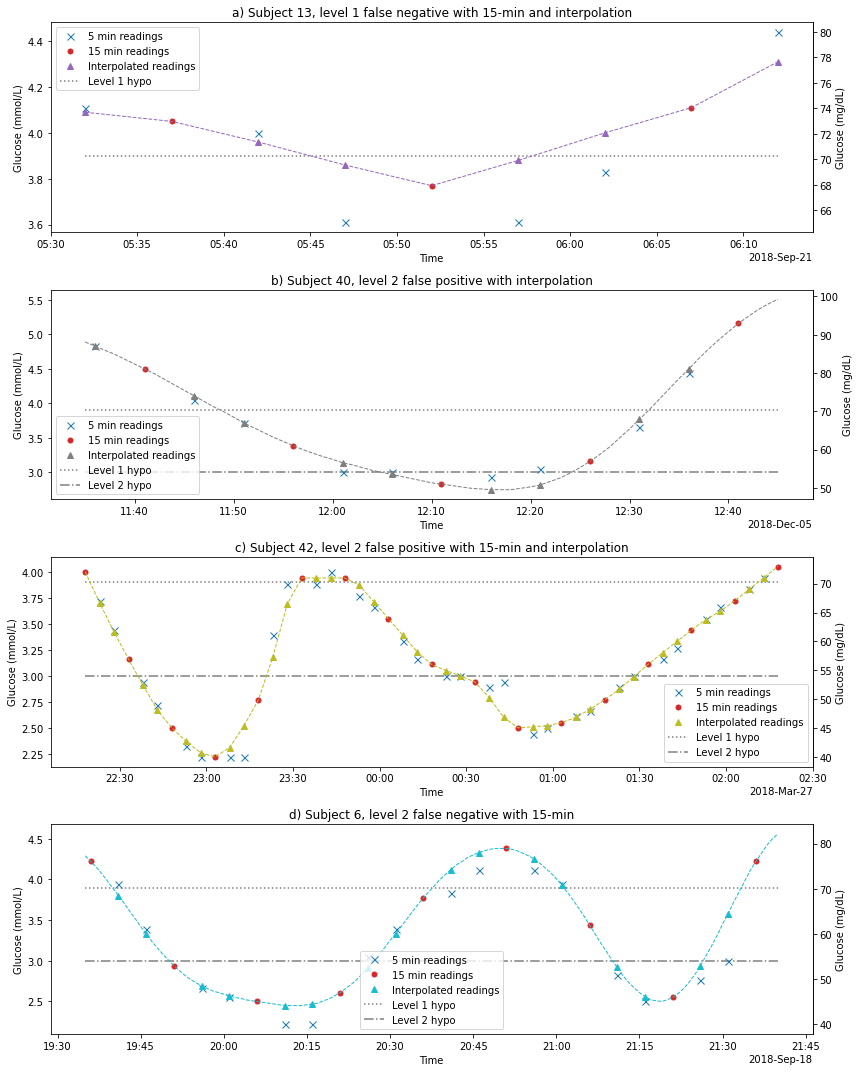

In [ ]:
# Create figure and set title of each subplot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 15))
ax1 = create_ax(sub_dfs[0], ax1, 'linear', 'C4', False)
ax1.set_title('a) Subject 13, level 1 false negative with 15-min and interpolation')
ax2 = create_ax(sub_dfs[1], ax2, 'polynomial_5', 'C7', True)
ax2.set_title('b) Subject 40, level 2 false positive with interpolation')
ax3 = create_ax(sub_dfs[2], ax3, 'pchip', 'C8', True)
ax3.set_title('c) Subject 42, level 2 false positive with 15-min and interpolation')
ax4 = create_ax(sub_dfs[3], ax4, 'rbf', 'C9', True)
ax4.set_title('d) Subject 6, level 2 false negative with 15-min')

for ax in ax1, ax2, ax3, ax4:
    secax = ax.secondary_yaxis('right', functions=(mmol2mg, mg2mmol))
    secax.set_ylabel('Glucose (mg/dL)')
fig.tight_layout()
fig.savefig('figure_3.svg')

## 4.4. Distribution of incorrect results by type

In [ ]:
aligned_results[aligned_results['col']=='poly3']

,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value,false_lv2
45322,poly3,helm_1,2020-05-12 04:01:19,2020-05-12 04:01:19,2020-05-12 04:21:19,0 days 00:20:00,False,2020-05-12 04:01:19,2020-05-12 04:21:19,0 days 00:20:00,False,0,0
45323,poly3,helm_1,2020-05-12 04:41:19,2020-05-12 04:41:19,2020-05-12 06:06:20,0 days 01:25:01,False,2020-05-12 04:46:20,2020-05-12 06:06:20,0 days 01:20:00,False,0,0
45324,poly3,helm_1,2020-05-12 20:21:21,2020-05-12 20:21:21,2020-05-12 20:41:21,0 days 00:20:00,False,NaT,NaT,NaT,NaN,-1,NaN
45325,poly3,helm_1,2020-05-15 14:21:28,2020-05-15 14:21:28,2020-05-15 14:41:28,0 days 00:20:00,False,2020-05-15 14:21:28,2020-05-15 14:41:28,0 days 00:20:00,False,0,0
45326,poly3,helm_1,2020-05-18 05:56:34,2020-05-18 05:56:34,2020-05-18 06:31:34,0 days 00:35:00,False,2020-05-18 05:56:34,2020-05-18 06:26:34,0 days 00:30:00,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56816,poly3,helm_988,2021-04-14 15:11:32,2021-04-14 15:11:32,2021-04-14 15:51:33,0 days 00:40:01,False,2021-04-14 15:16:32,2021-04-14 15:51:33,0 days 00:35:01,False,0,0
56817,poly3,helm_988,2021-04-15 08:06:35,2021-04-15 08:06:35,2021-04-15 08:46:36,0 days 00:40:01,False,2021-04-15 08:06:35,2021-04-15 08:46:36,0 days 00:40:01,False,0,0
56818,poly3,helm_988,2021-04-15 10:26:36,2021-04-15 10:26:36,2021-04-15 11:06:35,0 days 00:39:59,False,2021-04-15 10:21:35,2021-04-15 11:06:35,0 days 00:45:00,False,0,0
56819,poly3,helm_988,2021-04-15 18:56:36,2021-04-15 18:56:36,2021-04-15 19:26:36,0 days 00:30:00,False,2021-04-15 18:56:36,2021-04-15 19:26:36,0 days 00:30:00,False,0,0


In [ ]:
aligned_results[aligned_results['col']=='poly3'].false_lv2.value_counts()

 0    11199
 1      185
-1      115
Name: false_lv2, dtype: int64

In [ ]:
def incorrect_subtypes(df_method):
    '''
    Calculate how many of the incorrect hypos are identified as other levels
    of hypo
    '''
    # Actual lv1, identified as lv2
    lv1_lv2 = df_method.loc[(df_method['5_min_lv2']==False) & 
                            (df_method['15_min_lv2']==True)].shape[0]
    # Actual lv2, identified as lv1
    lv2_lv1 = df_method.loc[(df_method['5_min_lv2']==True) & 
                            (df_method['15_min_lv2']==False)].shape[0]
    # Actual lv1, identified as not a hypo
    lv1_none = df_method.loc[(df_method['5_min_lv2']==False) & 
                             (pd.isnull(df_method['15_min_lv2']))].shape[0]
    # Actual no hypo, identified as lv1 hypo
    none_lv1 = df_method.loc[(pd.isnull(df_method['5_min_lv2'])) & 
                             (df_method['15_min_lv2']==False)].shape[0]
    # Actual lv2 hypo, identified as no hypo
    lv2_none = df_method.loc[(df_method['5_min_lv2']==True) & 
                             (pd.isnull(df_method['15_min_lv2']))].shape[0] 
    # Actual no hypo, identified as level 2 hypo
    none_lv2 = df_method.loc[(pd.isnull(df_method['5_min_lv2'])) & 
                             (df_method['15_min_lv2']==True)].shape[0]
    return pd.DataFrame([[lv1_lv2, lv2_lv1,  lv1_none, none_lv1, lv2_none, 
                          none_lv2]])

In [ ]:
# Call incorrect_subtypes and rename columns
results = aligned_results.groupby('col').apply(incorrect_subtypes).unstack()
results.columns=['lv1_lv2', 'lv2_lv1', 'lv1_none','none_lv1', 'lv2_none', 
                 'none_lv2']

In [ ]:
# Shows the distibution of incorrectly identified hypos
# Columns show actual_predicted
results

,lv1_lv2,lv2_lv1,lv1_none,none_lv1,lv2_none,none_lv2
col,,,,,,
15_min,28,631,0,0,0,0
akima,165,149,0,0,0,0
linear,64,256,0,0,0,0
pchip,169,141,0,0,0,0
poly3,185,115,0,0,0,0
poly5,200,119,0,0,0,0
poly7,203,124,0,0,0,0


## 4.5. Distribution of incorrect results by person

In [ ]:
# Combine baseline and 6-month periods for IDs
df['ID_code'] = df.ID.apply(lambda x: x[:4])
aligned_results['ID_code'] = aligned_results.ID.apply(lambda x: x[:4])

In [ ]:
def number_false_values(sub_id):
    '''
    Calculate the number of people who have different types of incorrect hypos
    '''
    # Number of incorrect results per person (all)
    FN_all = sub_id.loc[sub_id.false_value == -1].shape[0]
    TP_all = sub_id.loc[sub_id.false_value == 0].shape[0]
    FP_all = sub_id.loc[sub_id.false_value == 1].shape[0]
    # Number of incorrect results per person (level 1)
    TPlv1 = sub_id[((sub_id['5_min_lv2'] == False) & 
                    (sub_id['15_min_lv2'] == False))].shape[0]
    FNlv1 = sub_id[(sub_id['5_min_lv2'] == False) & 
                   (sub_id['15_min_lv2'] != False)].shape[0]
    FPlv1 = sub_id[(sub_id['5_min_lv2'] != False) & 
                   (sub_id['15_min_lv2'] == False)].shape[0]
    # Number of incorrect results per person (level 2)
    TPlv2 = sub_id[((sub_id['5_min_lv2'] == True) & 
                    (sub_id['15_min_lv2'] == True))].shape[0]
    FNlv2 = sub_id[(sub_id['5_min_lv2'] == True) & 
                   (sub_id['15_min_lv2'] != True)].shape[0]
    FPlv2 = sub_id[(sub_id['5_min_lv2'] != True) & 
                   (sub_id['15_min_lv2'] == True)].shape[0]
    
    return pd.DataFrame([[TP_all, FP_all, FN_all, TPlv1, FPlv1, FNlv1, TPlv2,
                          FPlv2, FNlv2]], columns=['TP_all', 'FP_all',
                                                   'FN_all', 'TPlv1', 'FPlv1',
                                                   'FNlv1', 'TPlv2', 'FPlv2',
                                                   'FNlv2'])

In [ ]:
# Call number_false_values for each ID
results_personal = aligned_results.groupby(['ID_code', 'col'], dropna=False).apply(number_false_values).reset_index().drop(columns='level_2')
results_personal

,ID_code,col,TP_all,FP_all,FN_all,TPlv1,FPlv1,FNlv1,TPlv2,FPlv2,FNlv2
0,1003,akima,19,0,0,11,1,0,7,0,1
1,1003,cubicspline,19,0,0,11,0,0,8,0,0
2,1003,cut_glc,19,0,0,11,1,0,7,0,1
3,1003,linear,19,0,0,11,1,0,7,0,1
4,1003,matern,19,0,0,11,0,0,8,0,0
5,1003,pchip,19,0,0,11,1,0,7,0,1
6,1003,polynomial_3,19,0,0,11,0,0,8,0,0
7,1003,polynomial_5,19,0,0,11,0,0,8,0,0
8,1003,polynomial_7,19,0,0,11,0,0,8,0,0
9,1003,rbf,19,0,0,11,0,0,8,0,0


In [ ]:
# Melt the dataframe to calculate the number of people who have incorrect 
# values, this shows us the distribution of incorrect results 
melted = results_personal.melt(id_vars=['ID_code', 'col'])
pd.DataFrame(melted.groupby(['col', 'variable']).apply(lambda x: x[x.value!=0].shape[0])).reset_index().pivot(index='col', columns='variable')

0                                                  
variable     FN_all FNlv1 FNlv2 FP_all FPlv1 FPlv2 TP_all TPlv1 TPlv2
col                                                                  
akima            10    15     8     11    18     8     62    60    49
cubicspline       9    15     7     12    17    11     62    60    49
cut_glc          29    26    20      2    18     1     62    60    47
linear           16    18    14      5    18     3     62    60    48
matern            9    15     7     14    17    12     62    60    49
pchip             9    15    10      8    16     8     62    60    48
polynomial_3      9    15     7     12    17    11     62    60    49
polynomial_5      8    16     6     14    17    13     62    60    49
polynomial_7     10    17     6     14    17    13     62    60    49
rbf              11    17     6     13    16    11     62    60    49
rq               15    19    12      9    19     7     62    60    48